In [7]:
import pandas as pd

df = pd.read_csv("uber_test.csv")
print(df.columns)


Index(['trip_id', 'driver_id', 'rider_id', 'city', 'pickup_lat', 'pickup_lng',
       'drop_lat', 'drop_lng', 'distance_km', 'fare_amount', 'status',
       'payment_method', 'pickup_time', 'drop_time', 'trip_duration_min',
       'hour', 'day_of_week', 'is_weekend', 'is_peak', 'geo_distance_km'],
      dtype='object')


In [8]:
import pandas as pd
import joblib
import numpy as np
import math
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# -------------------------------------------------
# Load models
# -------------------------------------------------
eta_model = joblib.load("models/lightgbm_eta_model.pkl")
demand_model = joblib.load("models/xgboost_demand_model.pkl")

print("ETA model expects:", eta_model.n_features_in_)
print("Demand model expects:", demand_model.n_features_in_)

# -------------------------------------------------
# Load dataset
# -------------------------------------------------
df = pd.read_csv("uber_test.csv")

# -------------------------------------------------
# Haversine distance
# -------------------------------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(math.radians(lat1))
        * math.cos(math.radians(lat2))
        * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

# -------------------------------------------------
# FEATURE BUILDER (6 FEATURES – ETA MODEL)
# -------------------------------------------------
def build_eta_features(row):
    distance_km = haversine(
        row["pickup_lat"],
        row["pickup_lng"],
        row["drop_lat"],
        row["drop_lng"]
    )

    pickup_time_ = pd.to_datetime(row["pickup_time"])
    hour = pickup_time_.hour
    day_of_week = pickup_time_.weekday()

    traffic_level = 2 if distance_km > 5 else 1
    is_peak_hour = 1 if hour in [8,9,10,17,18,19] else 0
    demand_index = 1 if is_peak_hour else 0

    return [[
        distance_km,
        traffic_level,
        hour,
        day_of_week,
        is_peak_hour,
        demand_index
    ]]

# -------------------------------------------------
# FEATURE BUILDER (3 FEATURES – DEMAND MODEL)
# -------------------------------------------------
def build_demand_features(row):
    distance_km = haversine(
        row["pickup_lat"],
        row["pickup_lng"],
        row["drop_lat"],
        row["drop_lng"]
    )

    pickup_time_ = pd.to_datetime(row["pickup_time"])
    hour = pickup_time_.hour
    traffic_level = 2 if distance_km > 5 else 1

    return [[distance_km, traffic_level, hour]]

# -------------------------------------------------
# Predictions
# -------------------------------------------------
eta_true, eta_pred = [], []
demand_true, demand_pred = [], []

fare_threshold = df["fare_amount"].median()

for _, row in df.iterrows():

    # ETA
    eta_features = build_eta_features(row)
    eta_pred.append(eta_model.predict(eta_features)[0])
    eta_true.append(row["trip_duration_min"])

    # Demand
    demand_features = build_demand_features(row)
    raw_pred = demand_model.predict(demand_features)[0]
    demand_prediction = 1 if raw_pred >= 0.5 else 0
    demand_pred.append(demand_prediction)
    demand_true.append(1 if row["fare_amount"] > fare_threshold else 0)

eta_true = np.array(eta_true)
eta_pred = np.array(eta_pred)
demand_true = np.array(demand_true)
demand_pred = np.array(demand_pred)

# -------------------------------------------------
# ETA METRICS
# -------------------------------------------------
mse = mean_squared_error(eta_true, eta_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(eta_true, eta_pred)
mape = np.mean(np.abs((eta_true - eta_pred) / eta_true)) * 100

# -------------------------------------------------
# DEMAND METRICS
# -------------------------------------------------
accuracy = accuracy_score(demand_true, demand_pred)
precision = precision_score(demand_true, demand_pred)
recall = recall_score(demand_true, demand_pred)
f1 = f1_score(demand_true, demand_pred)

# -------------------------------------------------
# Results
# -------------------------------------------------
print("\n📊 ETA MODEL EVALUATION")
print(f"MSE   : {mse:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"MAE   : {mae:.4f}")
print(f"MAPE  : {mape:.2f}%")

print("\n📊 DEMAND MODEL EVALUATION")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")


ETA model expects: 6
Demand model expects: 3

📊 ETA MODEL EVALUATION
MSE   : 360.4679
RMSE  : 18.9860
MAE   : 17.0140
MAPE  : 77.60%

📊 DEMAND MODEL EVALUATION
Accuracy  : 0.5000
Precision : 0.5000
Recall    : 1.0000
F1-score  : 0.6667


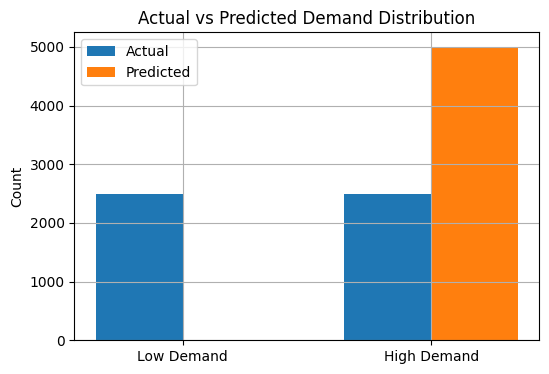

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

labels = ["Low Demand", "High Demand"]
actual_counts = np.bincount(demand_true, minlength=2)
predicted_counts = np.bincount(demand_pred, minlength=2)

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, actual_counts, width, label="Actual")
plt.bar(x + width/2, predicted_counts, width, label="Predicted")

plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("Actual vs Predicted Demand Distribution")
plt.legend()
plt.grid(True)
plt.show()
